In [52]:
# !git clone 'https://github.com/Lorenz92/SKADC1.git'
# % cd SKADC1
# !echo $PWD

In [1]:
import pandas as pd
import numpy as np
import requests
import matplotlib.pyplot as plt
import sys
from astropy.io import fits
import os
import statistics

import src.dataset as dataset
import src.datasetv2 as v2
import src.config as config
from src.utils import *
import src.preprocessing as prep
import src.models as models
import src.losses as loss

from keras import backend as K

path = config.TRAIN_PATCHES_FOLDER
%load_ext autoreload
%autoreload 2

np.random.seed(config.RANDOM_SEED)

In [2]:
# Dataset parsing and loading
# use "subset" in config file to load a small portion of data for development/debugging purposes
ska_dataset = v2.SKADatasetv2()
ska_dataset.load_dataset()

Dataset shape: (19222, 15)


,ID,RA (core),DEC (core),RA (centroid),DEC (centroid),FLUX,Core frac,BMAJ,BMIN,PA,SIZE,CLASS,SELECTION,x,y
0,24121695,-0.642227,-29.775242,-0.642316,-29.775211,0.000035,0.000000,5.600,5.551,328.554,1,1,1,19704.519,17712.942
1,20167150,-0.390473,-29.867493,-0.390667,-29.868851,0.029555,0.016924,107.110,43.263,191.258,1,1,1,18401.338,17160.919
2,20045120,-0.021411,-29.643486,-0.021359,-29.643561,0.000653,0.012185,5.037,3.525,276.587,1,1,1,16493.600,18506.577
3,33938384,-0.316375,-29.697647,-0.316375,-29.697647,0.000017,0.000000,0.847,0.266,346.641,2,1,1,18020.319,18182.095
4,7527248,-0.336528,-29.627335,-0.336527,-29.627338,0.000054,0.044763,3.343,1.515,279.006,1,1,1,18125.824,18600.680


In [3]:
ska_dataset.load_train_image()

Loading FITS file c:\Users\alice\Desktop\universita_AI\deep_learning\SKADC1\data\training\560Mhz_1000h.fits


### Preprocessing

In [4]:
ska_dataset.process_dataset()
#coords = ska_dataset._convert_boxes_to_px_coord(ska_dataset.raw_train_df, data_560Mhz_1000h_fits[0].header )

100%|██████████| 19222/19222 [00:10<00:00, 1785.68it/s]
Initial dataset shape: (19222, 15)
Found 15 boxes with zero area
Rows to be deleted: 15
New dataset shape: (19207, 15)
Extending dataset with new computed columns...
Final cleaned dataset shape: (19207, 24)

Enlarging bboxes...
DONE - Enlarging bboxes...


In [5]:
df_train = ska_dataset.cleaned_train_df
df_train.shape
df_train.head()

,ID,RA (core),DEC (core),RA (centroid),DEC (centroid),FLUX,Core frac,BMAJ,BMIN,PA,...,y,x1,y1,x2,y2,major_semia_px,minor_semia_px,pa_in_rad,width,height
0,24121695,-0.642227,-29.775242,-0.642316,-29.775211,0.000035,0.000000,5.600,5.551,328.554,...,17712.942,19699.889820,17708.334874,19709.135520,17717.543623,4.633850,4.593304,5.734349,9.245699,9.208748
1,20167150,-0.390473,-29.867493,-0.390667,-29.868851,0.029555,0.016924,107.110,43.263,191.258,...,17160.919,18314.128617,17121.775102,18488.540079,17200.059688,88.630651,35.798972,3.338082,174.411463,78.284586
2,20045120,-0.021411,-29.643486,-0.021359,-29.643561,0.000653,0.012185,5.037,3.525,276.587,...,18506.577,16490.663037,18502.418816,16496.536575,18510.726749,4.167982,2.916843,4.827354,5.873538,8.307933
3,33938384,-0.316375,-29.697647,-0.316375,-29.697647,0.000017,0.000000,0.847,0.266,346.641,...,18182.095,18019.631633,18181.823147,18020.999232,18182.360119,0.700870,0.220108,6.050027,1.367598,0.536972
4,7527248,-0.336528,-29.627335,-0.336527,-29.627338,0.000054,0.044763,3.343,1.515,279.006,...,18600.680,18124.509296,18597.936034,18127.132703,18603.414392,2.766243,1.253622,4.869573,2.623407,5.478358


In [7]:
df_train[['width', 'height']].describe()

,width,height
count,19207.000000,19207.000000
mean,4.075587,4.093373
std,3.459175,3.359250
min,0.009930,0.009930
25%,2.316125,2.356320
50%,3.475087,3.470834
75%,4.761761,4.780523
max,174.411463,92.846556


(3187, 3491)

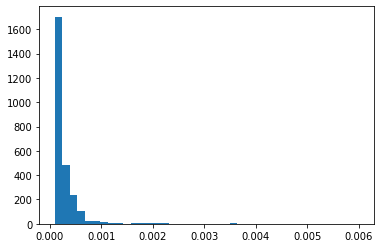

In [6]:
plot_Noise_Hist = True
ska_dataset.cut_preprocess_image(plot_Noise_Hist)
ska_dataset.data_560Mhz_1000h_train.shape


In [7]:
patch_list={}
show_plot=True
patch_list = ska_dataset.generate_patches(show_plot) # Remember to remove internal return

Error: Pip module Unable to parse debugpy output, please log an issue with https://github.com/microsoft/vscode-jupyter is required for debugging cells. You will need to install it to debug cells.

In [15]:
# TODO: trasfromare in attributo della classe dataset
class_list = ska_dataset.proc_train_df['class_label'].unique()
print(class_list)

num_classes = len(ska_dataset.proc_train_df['class_label'].unique())
print(num_classes)

['1_1' '2_1' '3_1']
3


## Preprocessing - TODO:
- unire bbox sovrapposte?

In [16]:
#TODO: spostare in dataset dopo aver sistemato la classe dataset
from sklearn.model_selection import train_test_split

train_patch_list, val_patch_list = train_test_split(patch_list, test_size=.2, random_state=42)
print(len(train_patch_list))
print(len(val_patch_list))

## datagen + calc_rpn -> rpn_net -> rpn_to_roi -> calc_iou -> cls_net

# Training

### Get FRCNN model

In [169]:
input_shape_1=(config.resizeFinalDim, config.resizeFinalDim,1)
input_shape_2=(None, 4)

rpn_model, detector_model, total_model = models.get_model(input_shape_1=input_shape_1, input_shape_2=input_shape_2, anchor_num=config.anchor_num, pooling_regions=7, num_rois=4, num_classes=len(class_list)+1, backbone=backbone)

rpn_model.summary()
cls_model.summary()
total_model.summary()

Model: "RegionProposal"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 600, 600, 1)]     0         
_________________________________________________________________
Custom_input_layer (Expander (None, 600, 600, 3)       6         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 600, 600, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 600, 600, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 300, 300, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 300, 300, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 300, 300, 128)  

### Load weights

In [181]:
models.load_weigths(rpn_model, detector_model, backbone, resume_train=True)
models.compile_models(rpn_model, detector_model, total_model, rpn_losses=[loss.rpn_loss_cls, loss.rpn_loss_regr], detector_losses=[loss.detector_loss_cls, loss.detector_loss_regr],class_list=class_list)

In [183]:
# Specifically checking backbone weights

# total_model.weights[24:25][0][0][0][0]

In [186]:
# Check that all of the pretrained weights have been loaded.
import numpy as np
for i, j in zip(total_model.weights, rpn_model.weights): 
    # print(i,j)
    assert np.allclose(i,j), 'Weights don\'t match!'

In [211]:
test = np.load('./model/vgg16/loss_history.npy')

In [212]:
print(test.shape)
test

(1, 5)


array([[0.04902495, 1.01560307, 0.70870161, 0.72695738, 0.5       ]])

### Train

In [208]:
from src.train import *
train_frcnn(rpn_model, detector_model, total_model, train_patch_list, val_patch_list, class_list, config.TRAIN_PATCHES_FOLDER, backbone='vgg16', resume_train=True)

  0%|          | 0/4 [00:00<?, ?it/s]Epoch 0/1
250_16624_16729_100

100%|██████████| 4/4 [01:04<00:00, 16.11s/it]

100%|██████████| 12/12 [00:00<00:00, 4048.56it/s]
Starting rpn model training on batch
Best IoU found in this run: 0.6697428999357536
Starting detector model training on batch
z = ,0.853981137
1/1 [==============================] - 73s 73s/step - rpn_cls: 0.0389 - rpn_regr: 0.8674 - detector_cls: 0.7280 - detector_regr: 0.8540 - average number of objects: 2.0000
Mean number of bounding boxes from RPN overlapping ground truth boxes: 8.0
Classifier accuracy for bounding boxes from RPN: 0.5
Loss RPN classifier: 0.038870107382535934
Loss RPN regression: 0.8674368262290955
Loss Detector classifier: 0.7280244827270508
Loss Detector regression: 0.8539811372756958
Elapsed time: 73.15143704414368
Total loss decreased from inf to 2.488312553614378, saving weights
  0%|          | 0/4 [00:00<?, ?it/s]Epoch 1/1
Average number of overlapping bounding boxes from RPN = 8.0 for 1 previous

In [209]:
loss = np.load(f"./model/{backbone}/loss_history.npy")
print(loss.shape)
loss

(1, 5)


array([[0.04902495, 1.01560307, 0.70870161, 0.72695738, 0.5       ]])

In [201]:
b = np.zeros((1, 5))
losses = np.concatenate((loss, b), axis=0)


In [205]:
losses.shape

(11, 5)

TODO - 20210508:
- troncamento rumore a 1e-6?

TODO - 20210605:
- implementare test loop che useremo sul validation set -> insieme
- lanciare training

TODO - 20210619:
- risolvere tutti i TODO
- finire classe datasetv2, testarla e sostituire classe dataset
- sistemare salvataggio loss su disco
- fare una prova su colab -> Lorenzo
- implementare resnet50
- implementare test su tutta la fits ed usare lo script della challenge

In [39]:
r_epochs = 50


plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.plot(np.arange(0, r_epochs), loss['loss_rpn_cls'], 'r')
plt.title('loss_rpn_cls')
plt.subplot(1,2,2)
plt.plot(np.arange(0, r_epochs), loss['loss_rpn_reg'], 'r')
plt.title('loss_rpn_reg')
plt.subplot(2,2,1)
plt.plot(np.arange(0, r_epochs), loss['loss_cls_reg'], 'r')
plt.title('loss_cls_clsdd')
plt.subplot(2,2,2)
plt.plot(np.arange(0, r_epochs), loss['loss_cls_cls'], 'r')
plt.title('loss_cls_reg')
plt.show()

plt.plot(np.arange(0, r_epochs), loss['loss_rpn'], 'r')
plt.title('total_loss')
plt.show()

TypeError: list indices must be integers or slices, not str

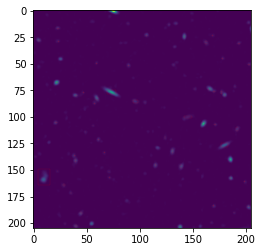

In [28]:
## DEBUG

patch = '1435_1781517815_205'
image_path = os.path.join(config.TRAIN_PATCHES_FOLDER, patch, f"{patch}.npy")
image_data_path = os.path.join(config.TRAIN_PATCHES_FOLDER, patch, f"{patch}.pkl")

p = np.load(image_path)
pdata = pd.read_pickle(image_data_path)

print_img(p, pdata)


In [ ]:
#TODO: Provare YOLO -> forse meglio le efficientNet
# Ablation study
# Provare, a parità di frequenza, le esposizioni diverse come canali

In [1]:
# from tensorflow.keras.applications import EfficientNetB0
# model = EfficientNetB0(weights='imagenet')